In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from nn_model import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 100
n_steps = 50
step_size = 0.1
n_iterations = 1024

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 1024/1024 [00:16<00:00, 63.93it/s]


>>> Simulation completed


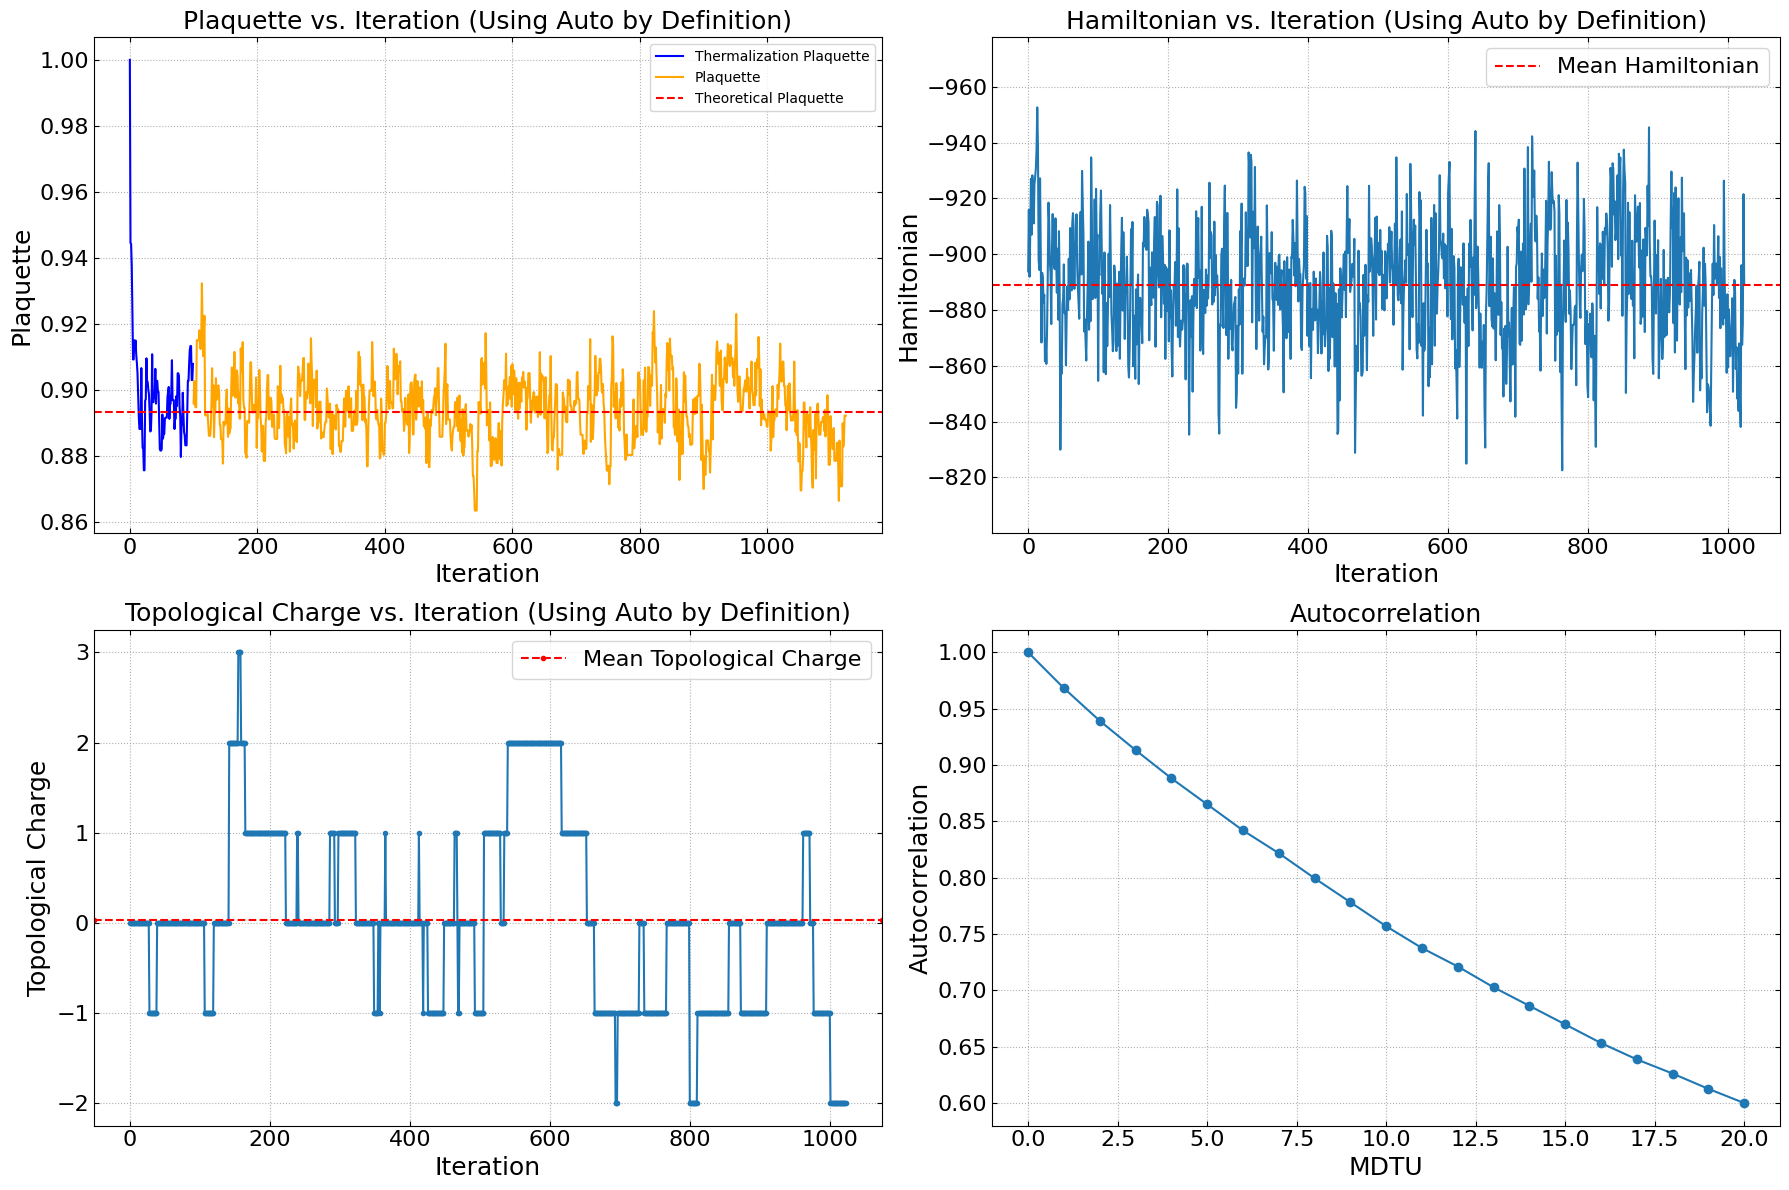

>>> Mean plaq:  0.8942205646308139
>>> Std of mean plaq:  0.00030676823296149


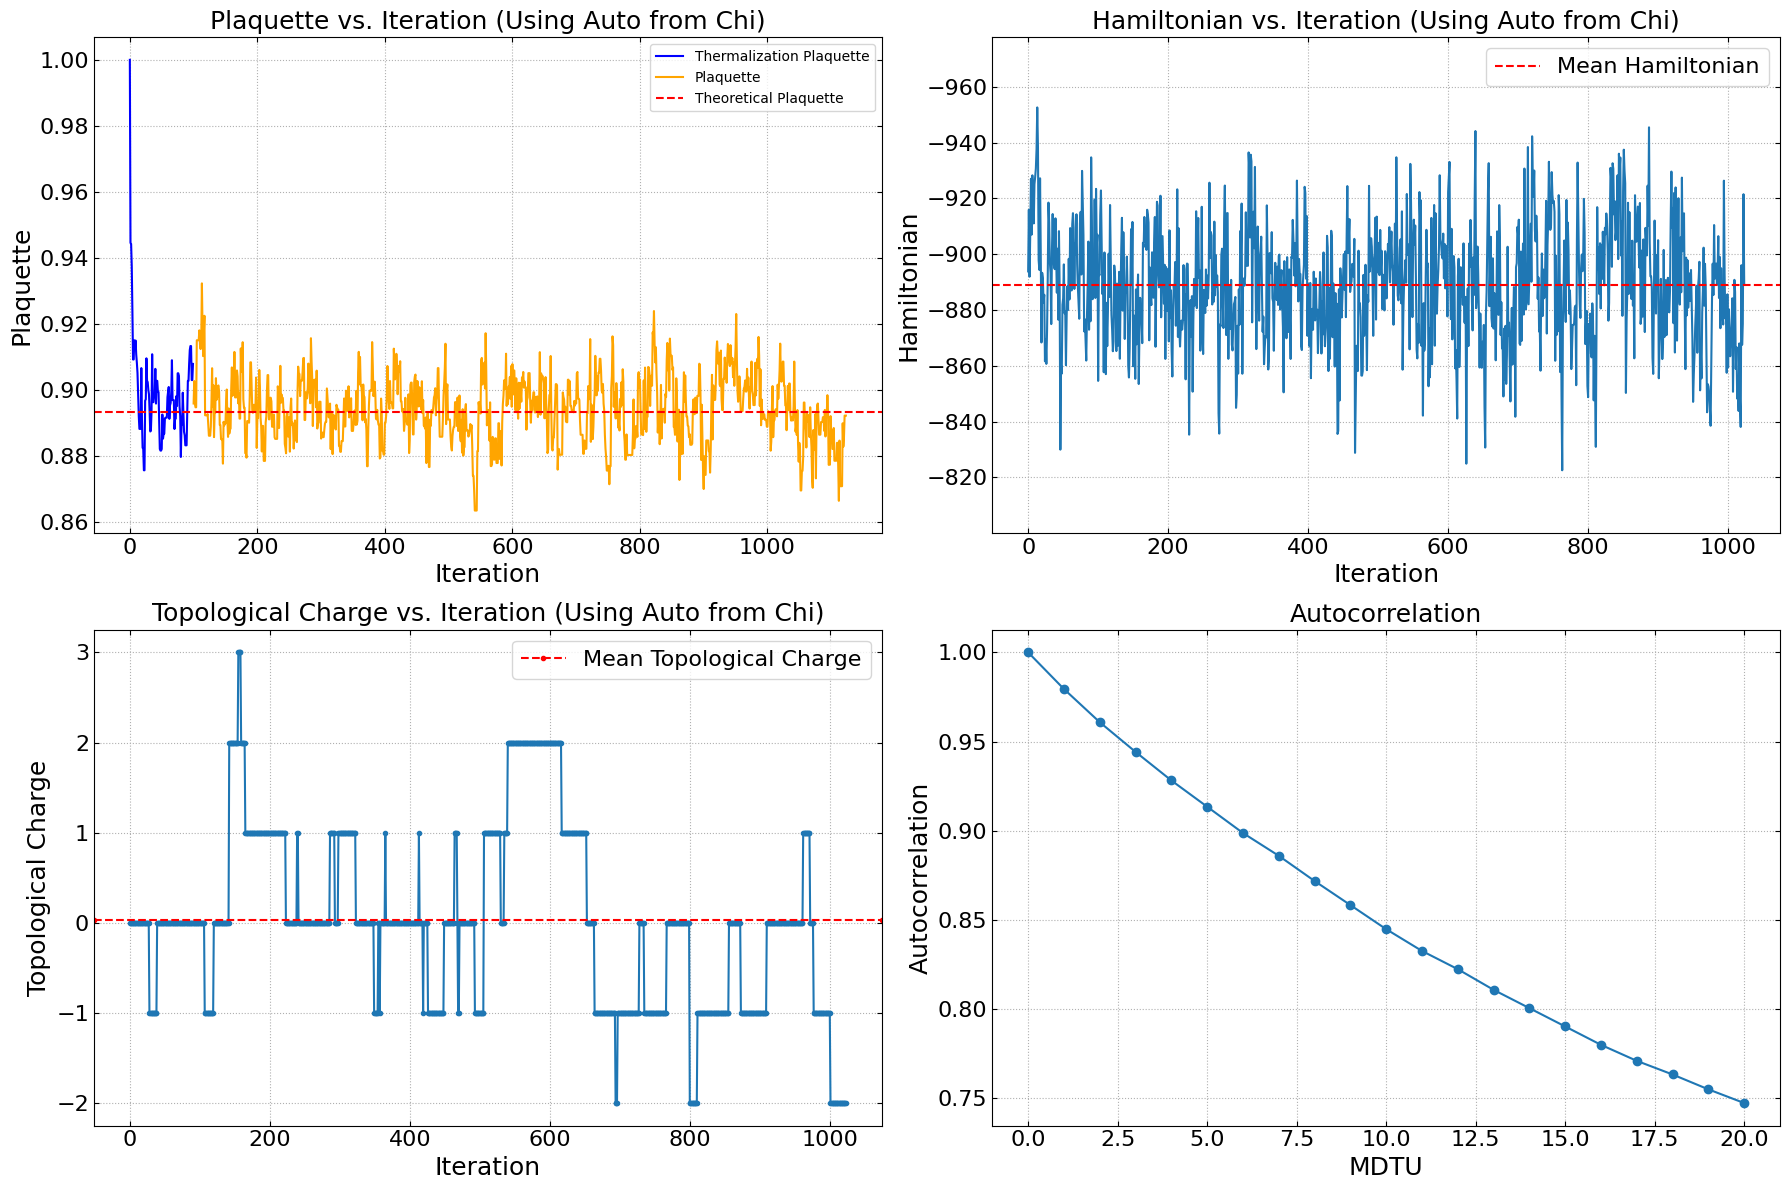

>>> Mean plaq:  0.8942205646308139
>>> Std of mean plaq:  0.00030676823296149
Thermalization acceptance rate: 0.8100
Acceptance rate: 0.7910


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Manual Field Transformation

Running HMC: 100%|██████████| 1024/1024 [00:57<00:00, 17.87it/s]


>>> Simulation completed


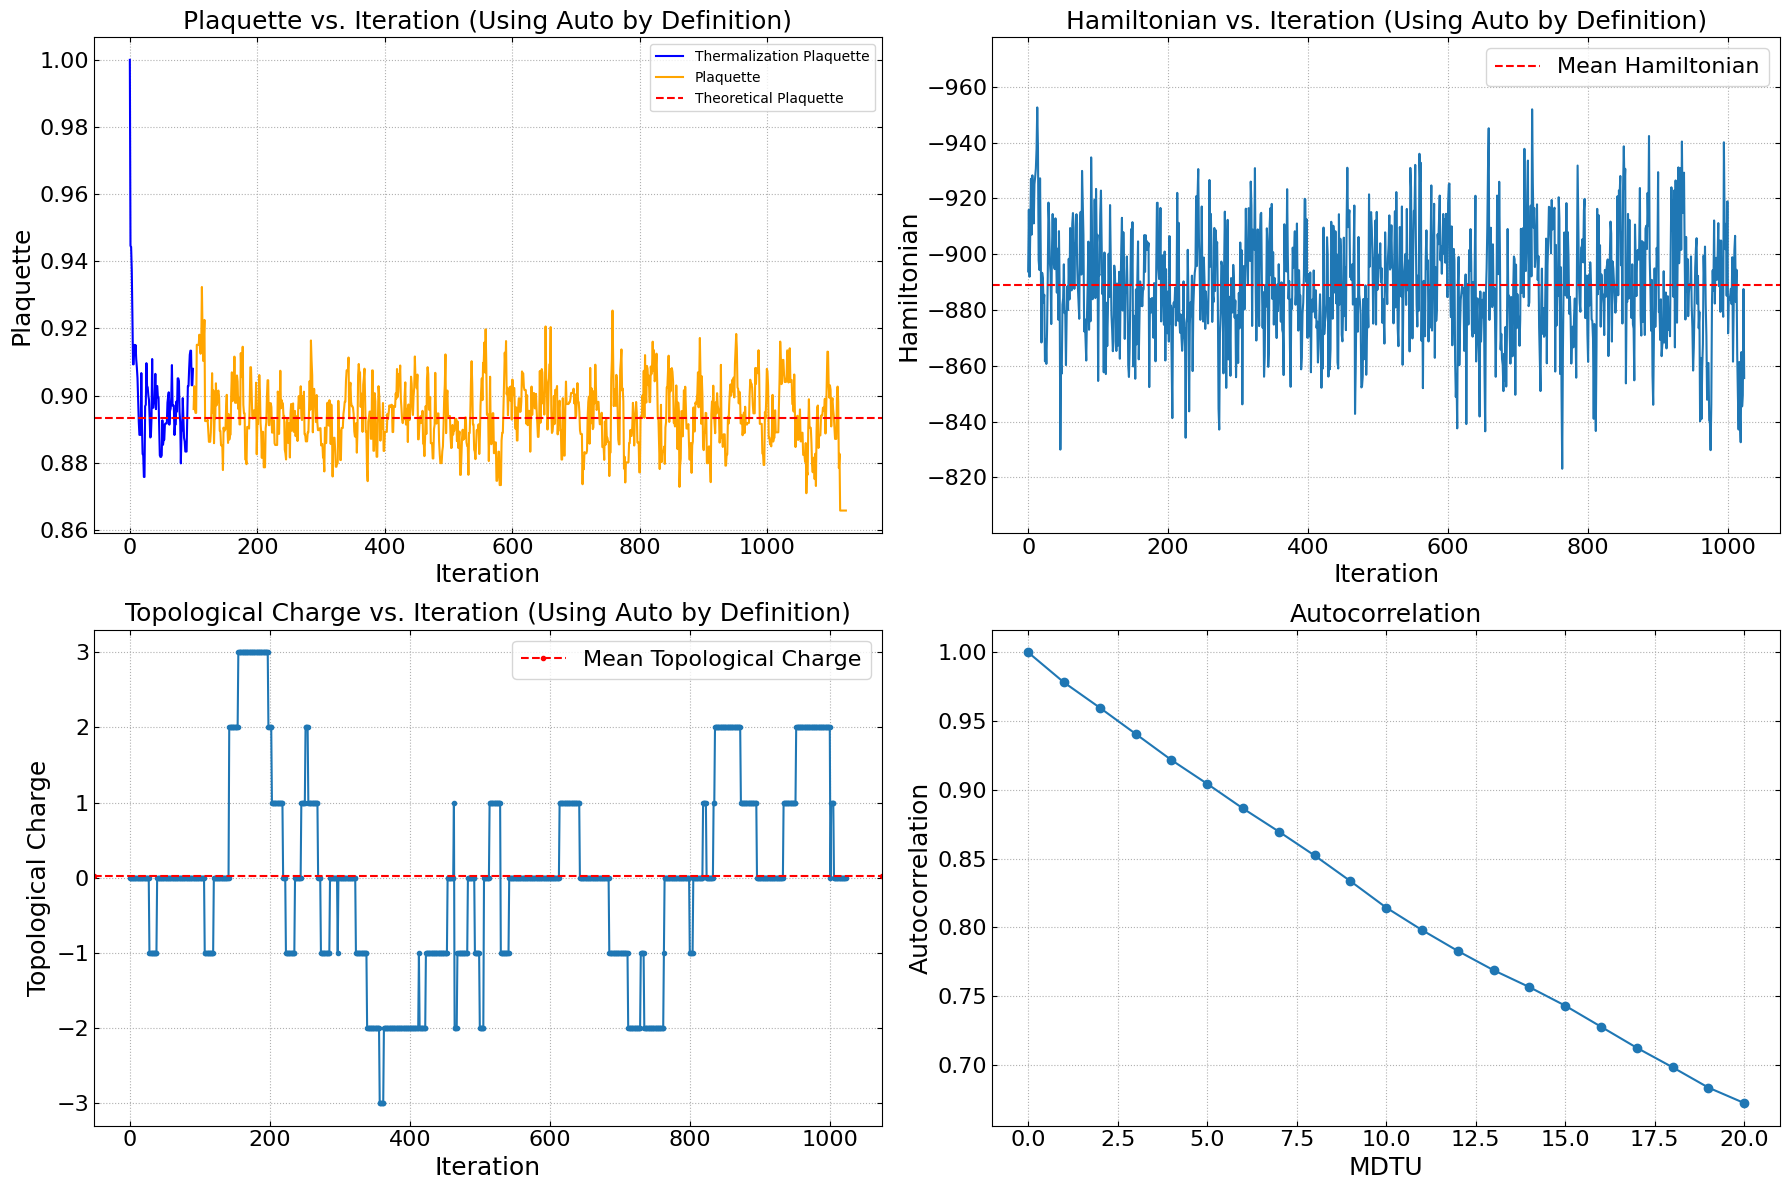

>>> Mean plaq:  0.894195630622562
>>> Std of mean plaq:  0.00030133840438207677


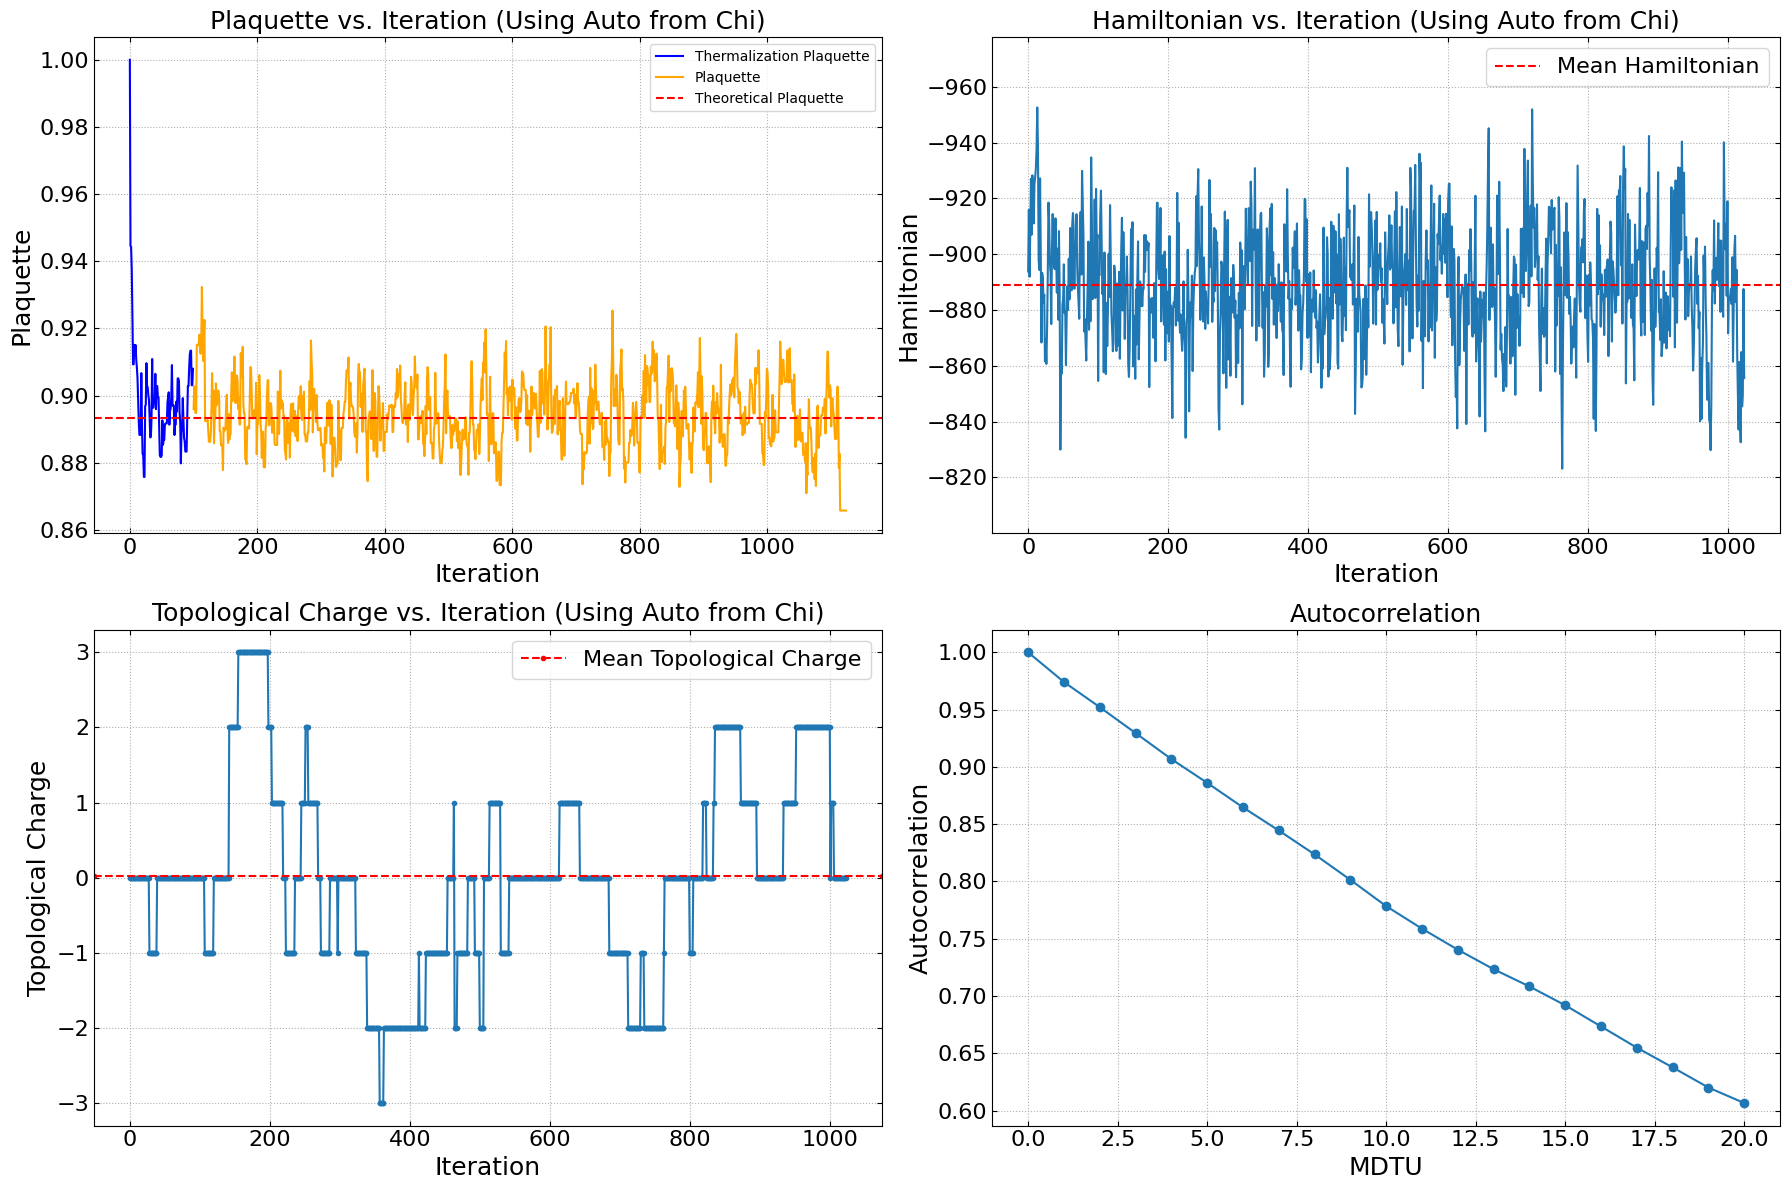

>>> Mean plaq:  0.894195630622562
>>> Std of mean plaq:  0.00030133840438207677
Thermalization acceptance rate: 0.8100
Acceptance rate: 0.7900


In [4]:
def manual_transformation(U, epsilon=0.01):
    # noise = epsilon * (torch.randn_like(U) + 0.5)
    return U + torch.pi

# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=manual_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")

# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network:   0%|          | 0/200 [00:00<?, ?it/s]

>>> Jacobian log det:  tensor(0.1763, device='cuda:0')


Training Neural Network:  10%|█         | 21/200 [00:01<00:07, 22.75it/s]

>>> Jacobian log det:  tensor(0.1113, device='cuda:0')


Training Neural Network:  20%|██        | 41/200 [00:01<00:04, 33.37it/s]

>>> Jacobian log det:  tensor(0.0645, device='cuda:0')


Training Neural Network:  30%|███       | 61/200 [00:01<00:03, 39.57it/s]

>>> Jacobian log det:  tensor(0.0776, device='cuda:0')


Training Neural Network:  40%|████      | 81/200 [00:02<00:02, 43.30it/s]

>>> Jacobian log det:  tensor(0.0800, device='cuda:0')


Training Neural Network:  50%|█████     | 101/200 [00:02<00:02, 46.19it/s]

>>> Jacobian log det:  tensor(0.0781, device='cuda:0')


Training Neural Network:  60%|██████    | 121/200 [00:03<00:01, 47.40it/s]

>>> Jacobian log det:  tensor(0.0763, device='cuda:0')


Training Neural Network:  70%|███████   | 141/200 [00:03<00:01, 48.03it/s]

>>> Jacobian log det:  tensor(0.0778, device='cuda:0')


Training Neural Network:  80%|████████  | 161/200 [00:03<00:00, 48.51it/s]

>>> Jacobian log det:  tensor(0.0861, device='cuda:0')


Training Neural Network:  90%|█████████ | 181/200 [00:04<00:00, 49.72it/s]

>>> Jacobian log det:  tensor(0.0857, device='cuda:0')


Training Neural Network: 100%|██████████| 200/200 [00:04<00:00, 45.83it/s]


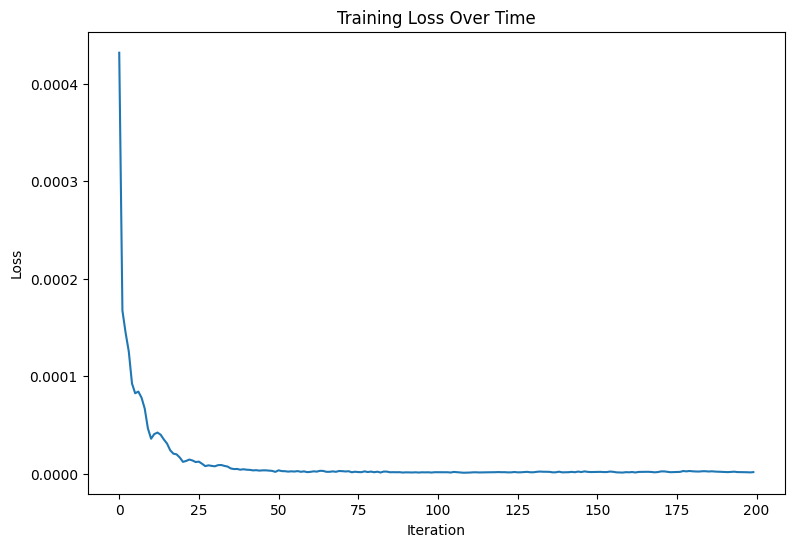


Neural Network Field Transformation Structure:
CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Thermalizing:  64%|██████▍   | 64/100 [00:20<00:11,  3.06it/s]


KeyboardInterrupt: 

In [5]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN', epsilon=0.1, epsilon_decay=1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_iterations=200)

# Print the trained neural network structure and parameters
print("\nNeural Network Field Transformation Structure:")
print(nn_transformation.model)


# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

In [ ]:
import torch.autograd.functional as F
from torch import linalg

def compute_jacobian_log_det(theta_new, field_transformation):
    """
    Compute the log determinant of the Jacobian matrix of the transformation.

    Parameters:
    -----------
    theta_new : torch.Tensor
        The new field configuration after transformation.
    """
    # Compute Jacobian using torch.autograd.functional.jacobian
    jacobian = F.jacobian(field_transformation, theta_new)

    # Reshape the Jacobian to a 2D matrix
    jacobian_2d = jacobian.reshape(theta_new.numel(), theta_new.numel())

    # Compute singular values
    s = linalg.svdvals(jacobian_2d)

    # Print any negative singular values
    negative_values = s[s < 0]
    if len(negative_values) > 0:
        print("Warning: Found negative singular values:", negative_values)

    # Compute log determinant as sum of log of singular values
    log_det = torch.sum(torch.log(s))

    return log_det

U_ini = torch.ones([2, lattice_size, lattice_size])
U_trans = nn_transformation.model(U_ini)

print(U_trans)
print(">>> Jacobian", compute_jacobian_log_det(U_ini, nn_transformation))


tensor([[-0.0551, -0.0576, -0.0542, -0.0548, -0.0548, -0.0548, -0.0548, -0.0548,
         -0.0548, -0.0548, -0.0548, -0.0548, -0.0548, -0.0468, -0.0466, -0.0327,
         -0.0678, -0.0661, -0.0643, -0.0676, -0.0676, -0.0676, -0.0676, -0.0676,
         -0.0676, -0.0676, -0.0676, -0.0676, -0.0676, -0.0640, -0.0615, -0.0472,
         -0.0505, -0.0560, -0.0615, -0.0674, -0.0674, -0.0674, -0.0674, -0.0674,
         -0.0674, -0.0674, -0.0674, -0.0674, -0.0674, -0.0597, -0.0660, -0.0596,
         -0.0456, -0.0493, -0.0560, -0.0619, -0.0619, -0.0619, -0.0619, -0.0619,
         -0.0619, -0.0619, -0.0619, -0.0619, -0.0619, -0.0570, -0.0617, -0.0596,
         -0.0456, -0.0493, -0.0560, -0.0619, -0.0619, -0.0619, -0.0619, -0.0619,
         -0.0619, -0.0619, -0.0619, -0.0619, -0.0619, -0.0570, -0.0617, -0.0596,
         -0.0456, -0.0493, -0.0560, -0.0619, -0.0619, -0.0619, -0.0619, -0.0619,
         -0.0619, -0.0619, -0.0619, -0.0619, -0.0619, -0.0570, -0.0617, -0.0596,
         -0.0456, -0.0493, -

In [ ]:
U_ini = torch.zeros([2, lattice_size, lattice_size])
# U_trans = manual_transformation(U_ini)
U_trans = nn_transformation(U_ini)

print(U_trans)
print(">>> Jacobian", compute_jacobian_log_det(U_ini, nn_transformation))


tensor([[[-5.1880e-03, -5.4235e-03, -5.3091e-03, -5.3091e-03, -5.3091e-03,
          -5.3091e-03, -5.3091e-03, -5.3091e-03, -5.3091e-03, -5.3091e-03,
          -5.3091e-03, -5.3091e-03, -5.3091e-03, -5.3091e-03, -5.3251e-03,
          -5.5087e-03],
         [-5.4481e-03, -5.6102e-03, -5.7030e-03, -5.7030e-03, -5.7030e-03,
          -5.7030e-03, -5.7030e-03, -5.7030e-03, -5.7030e-03, -5.7030e-03,
          -5.7030e-03, -5.7030e-03, -5.7030e-03, -5.7030e-03, -5.7168e-03,
          -5.6741e-03],
         [-5.4321e-03, -5.4109e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03,
          -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03,
          -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4319e-03,
          -5.4610e-03],
         [-5.4321e-03, -5.4109e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03,
          -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03,
          -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4181e-03, -5.4319e-03,
          -5.4610e-03],
    